In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

## Generalized Function to Load Data

In [2]:
def load_data(folder_path, pattern_prefix):
    """
    Load data from Excel files with flexible naming pattern
    
    Args:
        folder_path: Path to directory containing Excel files
        pattern_prefix: The middle part of the filename (e.g., "Location" or "Scenarios")
                       Files should be named like f"SA_{pattern_prefix}_*.xlsx"
    
    Returns:
        Nested dictionary: {name: {sheet: DataFrame}}
    """
    # Verify the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The directory {folder_path} does not exist")
    
    # Create regex pattern to extract names
    pattern = re.compile(fr'SA_{pattern_prefix}_(.*?)\.xlsx')
    
    # Get all names from filenames
    names = []
    for f in os.listdir(folder_path):
        match = pattern.match(f)
        if match:
            names.append(match.group(1))
    
    # Initialize nested dictionary
    data_dict = {name: {} for name in names}
    
    # Read each file and its sheets
    for name in data_dict.keys():
        filename = f"SA_{pattern_prefix}_{name}.xlsx"
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Read all sheets from the Excel file
            sheets = pd.read_excel(file_path, sheet_name=None)
            
            # Store each sheet (Fold_1 to Fold_5) in the dictionary
            for sheet_num in range(1, 6):
                sheet_name = f"Fold_{sheet_num}"
                if sheet_name in sheets:
                    data_dict[name][sheet_name] = sheets[sheet_name]
                else:
                    print(f"Warning: Sheet {sheet_name} not found in {filename}")
                    
        except FileNotFoundError:
            print(f"Warning: File {filename} not found in {folder_path}")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    return data_dict

## Generalized Function to Stacked Algorithm Performance Plot

In [3]:
def prepare_stacked_data(data, fields):
    stacked_data = []
    
    for field, folds in data.items():
        for algorithm in ['LP', 'SO', 'RO']:
            capex_sum = opex_hvac_sum = opex_c_sum = 0
            count = 0
            
            for fold, df in folds.items():
                alg_df = df[df['Algorithm'] == algorithm]
                if not alg_df.empty:
                    capex_sum += alg_df['Training Capital Cost'].mean()
                    opex_hvac_sum += alg_df['Testing HVAC Cost'].mean()
                    opex_c_sum += alg_df['Testing Critical Load Cost'].mean()
                    count += 1
            
            if count > 0:
                stacked_data.append({
                    fields: field,
                    'Algorithm': algorithm,
                    'CaPEX': capex_sum / count,
                    'OPEX HVAC': opex_hvac_sum / count,
                    'OPEX C': opex_c_sum / count,
                    'Total': (capex_sum + opex_hvac_sum + opex_c_sum) / count
                })
    
    return pd.DataFrame(stacked_data)


## Generalized Function to do Capacity Bar Plot

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

def scenario_capacity_barplot(location_data, SA_name, plot_name, special_scenarios, scenario_order=None):
    # IEEE-compliant style
    mpl.rcParams['figure.dpi'] = 300
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams.update({
        'axes.titlesize': 8,
        'axes.labelsize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 8
    })

    # Compute averages across folds
    scenario_avgs = {}
    for scenario, folds in location_data.items():
        all_folds = pd.concat(folds.values())
        scenario_avgs[scenario] = all_folds.groupby('Algorithm')[
            ['PV_Size', 'Battery_Size', 'PCM_Heating_Size', 'PCM_Cooling_Size']
        ].mean().reset_index()

    # Scenario order
    if scenario_order is not None:
        all_scenarios = [s for s in scenario_order if s in scenario_avgs]
    else:
        other_scenarios = [s for s in sorted(scenario_avgs.keys()) if s not in special_scenarios]
        all_scenarios = special_scenarios + other_scenarios

    n_scenarios = len(all_scenarios)
    fig_width = max(6, 7.16)  # Fixed 2-column width (IEEE)
    fig = plt.figure(figsize=(fig_width, 3))  # Adjust height as needed
    gs = fig.add_gridspec(1, n_scenarios, width_ratios=[1] * n_scenarios, wspace=0.3)

    appliances = {
        'PV_Size': {'color': '#FFD700', 'label': 'PV'},
        'Battery_Size': {'color': '#32CD32', 'label': 'Battery'},
        'PCM_Heating_Size': {'color': '#FF6347', 'label': 'PCM Heat'},
        'PCM_Cooling_Size': {'color': '#1E90FF', 'label': 'PCM Cool'}
    }

    # Determine y-axis scale for consistency
    if n_scenarios > len(special_scenarios):
        other_data = pd.concat([scenario_avgs[s] for s in all_scenarios[len(special_scenarios):]])
        y_min = other_data[list(appliances.keys())].min().min() * 0.9
        y_max = other_data[list(appliances.keys())].max().max() * 1.1
    else:
        y_min, y_max = None, None

    for i, scenario in enumerate(all_scenarios):
        ax = fig.add_subplot(gs[0, i])
        data = scenario_avgs[scenario]

        for j, algorithm in enumerate(['LP', 'SO', 'RO']):
            alg_data = data[data['Algorithm'] == algorithm]
            x_pos = j
            offset = 0
            for k, appliance in enumerate(appliances.keys()):
                ax.bar(x_pos + offset, alg_data[appliance].values[0], 0.2,
                       color=appliances[appliance]['color'],
                       label=appliances[appliance]['label'] if j == 0 else "")
                offset += 0.2

        ax.set_title(scenario, fontsize=8, fontweight='bold')
        ax.set_xticks([0.3, 1.3, 2.3])
        ax.set_xticklabels(['LP', 'SO', 'RO'])
        ax.set_xlabel('Algorithm')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        if i < len(special_scenarios) or i == len(special_scenarios):
            ax.set_ylabel('Average Capacity')
        else:
            ax.set_ylabel('')
        if y_min is not None and y_max is not None:
            ax.set_ylim(y_min, y_max)

    handles = [mpl.patches.Patch(color=props['color'], label=props['label']) for props in appliances.values()]
    fig.legend(handles=handles,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.02),
               ncol=4,
               fontsize=8,
               frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(f'{plot_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


## Stacked Bar Plot for Locations

In [25]:
def plot_grouped_stacked_bars_ieee_loc(data, SA_name, plot_name):
    mpl.rcParams['figure.dpi'] = 300
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams.update({
        'axes.titlesize': 8,
        'axes.labelsize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'figure.titlesize': 8
    })

    stacked_df = prepare_stacked_data(data, SA_name)
    group1 = ['Alaska', 'Minnesota']
    group2 = ['Arizona', 'California', 'Florida']
    group1 = [loc for loc in group1 if loc in stacked_df[SA_name].unique()]
    group2 = [loc for loc in group2 if loc in stacked_df[SA_name].unique()]
    algorithms = ['LP', 'SO', 'RO']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    fig, axes = plt.subplots(1, 2, figsize=(7.16, 3), dpi=300)
    plt.subplots_adjust(wspace=0.3)
    width = 0.25
    LABEL_Y_POSITION = -0.15
    LABEL_FONTSIZE = 8
    LABEL_FONTWEIGHT = 'bold'

    # --- Group 1 ---
    ax1 = axes[0]
    x_tick_positions = []
    x_tick_labels = []
    region_tick_positions = []
    region_tick_labels = []
    for i, loc in enumerate(group1):
        loc_df = stacked_df[stacked_df[SA_name] == loc]
        x_pos = np.arange(len(algorithms)) + i * (len(algorithms) + 1)
        bottom = np.zeros(len(algorithms))
        for j, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [loc_df[loc_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            ax1.bar(x_pos, values, width, bottom=bottom, color=colors[j], edgecolor='black', linewidth=0.8)
            bottom += np.array(values)
        for k, xpos in enumerate(x_pos):
            x_tick_positions.append(xpos)
            x_tick_labels.append(algorithms[k])
        region_tick_positions.append(np.mean(x_pos))
        region_tick_labels.append(loc)
    ax1.set_ylim(0, 19000)
    ax1.set_ylabel('Cost ($)')
    ax1.set_xticks(x_tick_positions)
    ax1.set_xticklabels(x_tick_labels)
    ax1.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    for xpos, label in zip(region_tick_positions, region_tick_labels):
        ax1.text(xpos, LABEL_Y_POSITION, label,
                 ha='center', va='top',
                 fontsize=LABEL_FONTSIZE,
                 fontweight=LABEL_FONTWEIGHT,
                 transform=ax1.get_xaxis_transform(),
                 clip_on=False)

    # --- Group 2 ---
    ax2 = axes[1]
    x_tick_positions = []
    x_tick_labels = []
    region_tick_positions = []
    region_tick_labels = []
    for i, loc in enumerate(group2):
        loc_df = stacked_df[stacked_df[SA_name] == loc]
        x_pos = np.arange(len(algorithms)) + i * (len(algorithms) + 1)
        bottom = np.zeros(len(algorithms))
        for j, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [loc_df[loc_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            ax2.bar(x_pos, values, width, bottom=bottom, color=colors[j], edgecolor='black', linewidth=0.8)
            bottom += np.array(values)
        for k, xpos in enumerate(x_pos):
            x_tick_positions.append(xpos)
            x_tick_labels.append(algorithms[k])
        region_tick_positions.append(np.mean(x_pos))
        region_tick_labels.append(loc)
    ax2.set_ylim(0, 3200)
    ax2.set_ylabel('Cost ($)')
    ax2.set_xticks(x_tick_positions)
    ax2.set_xticklabels(x_tick_labels)
    ax2.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    for xpos, label in zip(region_tick_positions, region_tick_labels):
        ax2.text(xpos, LABEL_Y_POSITION, label,
                 ha='center', va='top',
                 fontsize=LABEL_FONTSIZE,
                 fontweight=LABEL_FONTWEIGHT,
                 transform=ax2.get_xaxis_transform(),
                 clip_on=False)

    handles = [mpl.patches.Patch(color=c, label=l) for c, l in zip(colors, ['CaPEX', 'OPEX HVAC', 'OPEX C'])]
    fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.02),
               ncol=3, fontsize=8, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(f'{plot_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


## Plot Locations Sensitivity Analysis

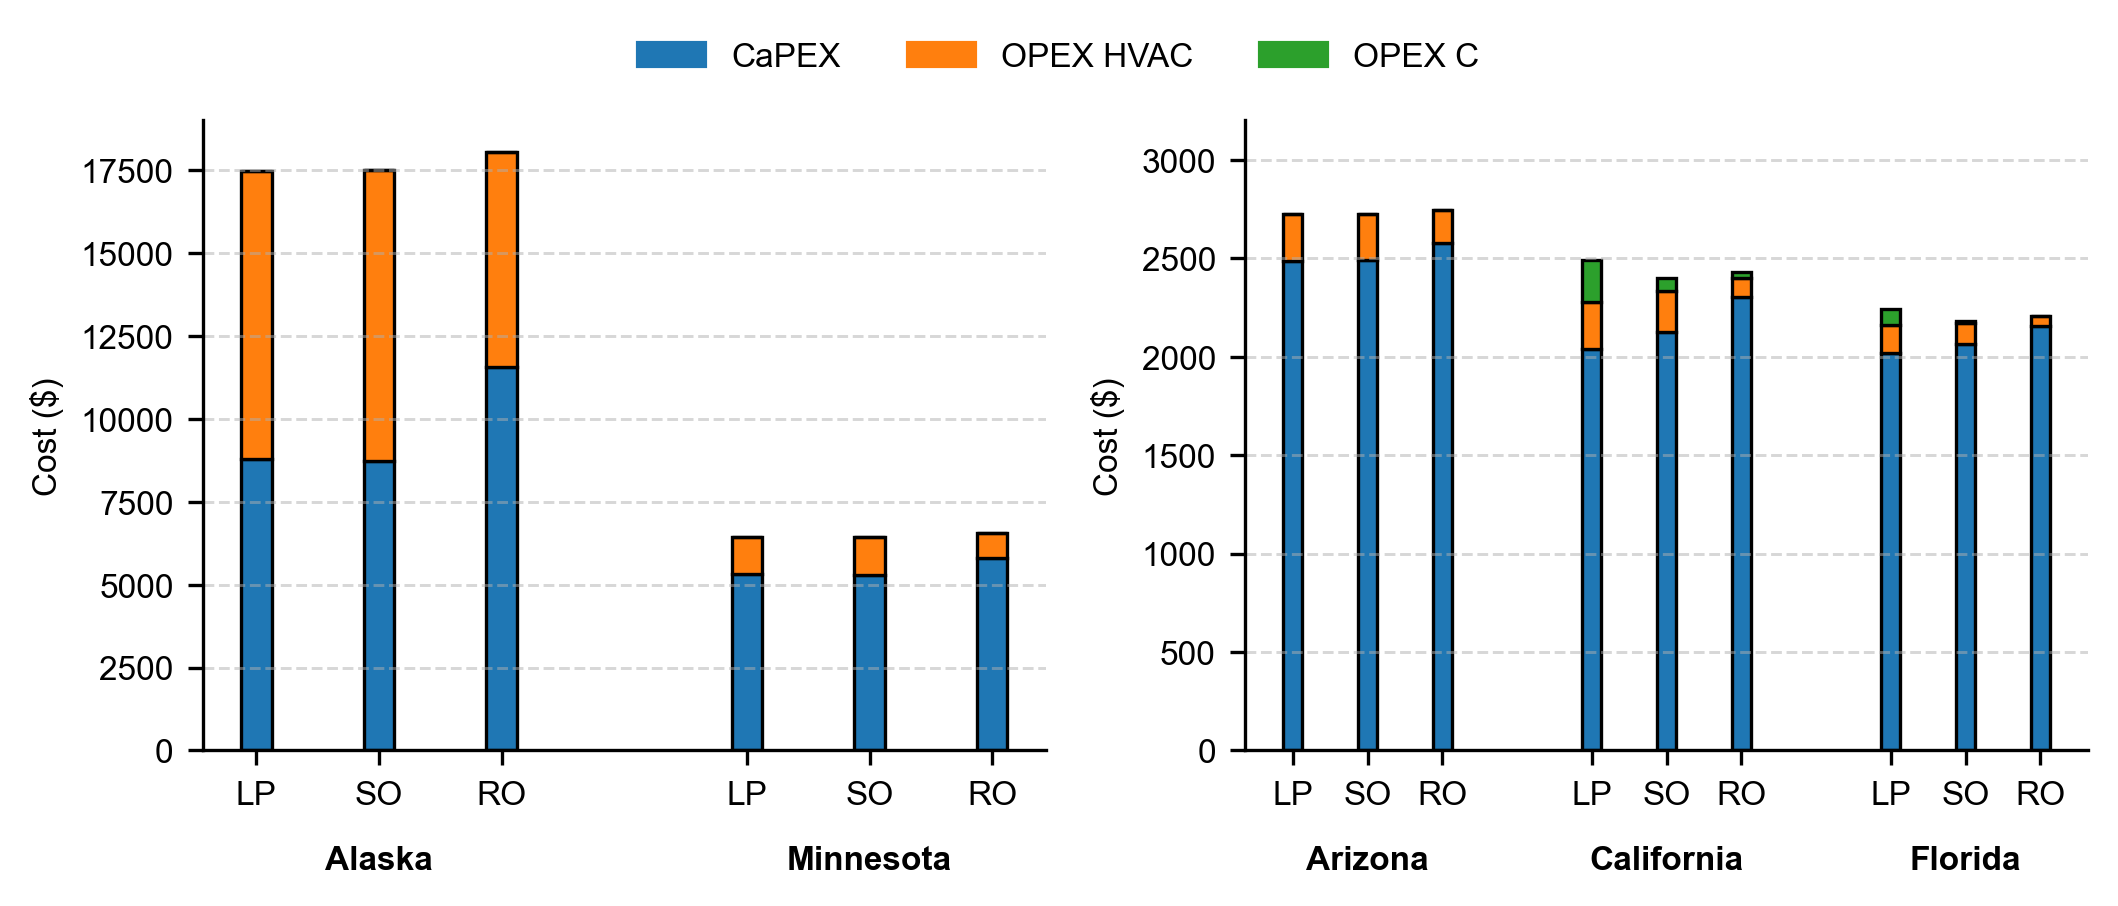

In [29]:
SA_name = 'Locations'

# Example usage for Locations:
location_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars_ieee_loc(location_data, 'Location', 'Locations_1')


## Capacity Bar Plot for Locations

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

def scenario_capacity_barplot_loc(location_data, SA_name, plot_name, special_scenarios, scenario_order=None):
    # Set IEEE-compliant font and style globally
    mpl.rcParams['figure.dpi'] = 300
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 8

    # Prepare data - average across folds
    scenario_avgs = {}
    for scenario, folds in location_data.items():
        all_folds = pd.concat(folds.values())
        scenario_avgs[scenario] = all_folds.groupby('Algorithm')[
            ['PV_Size', 'Battery_Size', 'PCM_Heating_Size', 'PCM_Cooling_Size']
        ].mean().reset_index()

    if scenario_order is not None:
        all_scenarios = [s for s in scenario_order if s in scenario_avgs]
    else:
        other_scenarios = [s for s in sorted(scenario_avgs.keys()) if s not in special_scenarios]
        all_scenarios = special_scenarios + other_scenarios

    group1 = [s for s in special_scenarios if s in scenario_avgs]
    group2 = [s for s in all_scenarios if s not in special_scenarios and s in scenario_avgs]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.16, 3), dpi=300)  # 2-column width, modest height
    plt.subplots_adjust(wspace=0.4)

    appliances = {
        'PV_Size': {'color': '#FFD700', 'label': 'PV'},
        'Battery_Size': {'color': '#32CD32', 'label': 'Battery'},
        'PCM_Heating_Size': {'color': '#FF6347', 'label': 'PCM Heat'},
        'PCM_Cooling_Size': {'color': '#1E90FF', 'label': 'PCM Cool'}
    }
    appliance_order = ['PV_Size', 'Battery_Size', 'PCM_Heating_Size', 'PCM_Cooling_Size']

    # Global y-limits
    if group2:
        other_data = pd.concat([scenario_avgs[s] for s in group2])
        y_min = other_data[list(appliances.keys())].min().min() * 0.9
        y_max = other_data[list(appliances.keys())].max().max() * 1.1
    else:
        y_min, y_max = None, None

    # Bar plot params
    bar_width = 0.15
    group_width = len(appliance_order) * bar_width * 1.2

    # --- Group 1 (special scenarios) ---
    for i, scenario in enumerate(group1):
        data = scenario_avgs[scenario]
        scenario_pos = i * (3 + 1)

        for j, algorithm in enumerate(['LP', 'SO', 'RO']):
            alg_data = data[data['Algorithm'] == algorithm]
            x_base = scenario_pos + j

            for k, appliance in enumerate(appliance_order):
                x_pos = x_base + k * bar_width - (len(appliance_order)*bar_width/2 - bar_width/2)
                height = alg_data[appliance].values[0]
                ax1.bar(x_pos, height, bar_width,
                        color=appliances[appliance]['color'],
                        label=appliances[appliance]['label'] if (i == 0 and j == 0) else "",
                        edgecolor='black', linewidth=0.5)

            ax1.text(x_base, -0.05, algorithm, ha='center', va='top',
                     fontsize=8, transform=ax1.get_xaxis_transform())

        ax1.text(scenario_pos+1, 1.05, scenario, ha='center', va='bottom',
                 fontsize=8, fontweight='bold', transform=ax1.get_xaxis_transform())

    ax1.set_ylabel('Average Capacity')
    ax1.grid(axis='y', linestyle='--', alpha=0.3)
    ax1.set_xticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # --- Group 2 (other scenarios) ---
    if group2:
        for i, scenario in enumerate(group2):
            data = scenario_avgs[scenario]
            scenario_pos = i * (3 + 1)

            for j, algorithm in enumerate(['LP', 'SO', 'RO']):
                alg_data = data[data['Algorithm'] == algorithm]
                x_base = scenario_pos + j

                for k, appliance in enumerate(appliance_order):
                    x_pos = x_base + k * bar_width - (len(appliance_order)*bar_width/2 - bar_width/2)
                    height = alg_data[appliance].values[0]
                    ax2.bar(x_pos, height, bar_width,
                            color=appliances[appliance]['color'],
                            label=appliances[appliance]['label'] if (i == 0 and j == 0) else "",
                            edgecolor='black', linewidth=0.5)

                ax2.text(x_base, -0.05, algorithm, ha='center', va='top',
                         fontsize=8, transform=ax2.get_xaxis_transform())

            ax2.text(scenario_pos+1, 1.05, scenario, ha='center', va='bottom',
                     fontsize=8, fontweight='bold', transform=ax2.get_xaxis_transform())

        ax2.set_ylabel('Average Capacity')
        if y_min is not None and y_max is not None:
            ax2.set_ylim(y_min, y_max)
        ax2.grid(axis='y', linestyle='--', alpha=0.3)
        ax2.set_xticks([])
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

    handles = [mpl.patches.Patch(color=props['color'], label=props['label'])
               for props in appliances.values()]
    fig.legend(handles=handles,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.02),
               ncol=4,
               fontsize=8,
               frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{plot_name}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


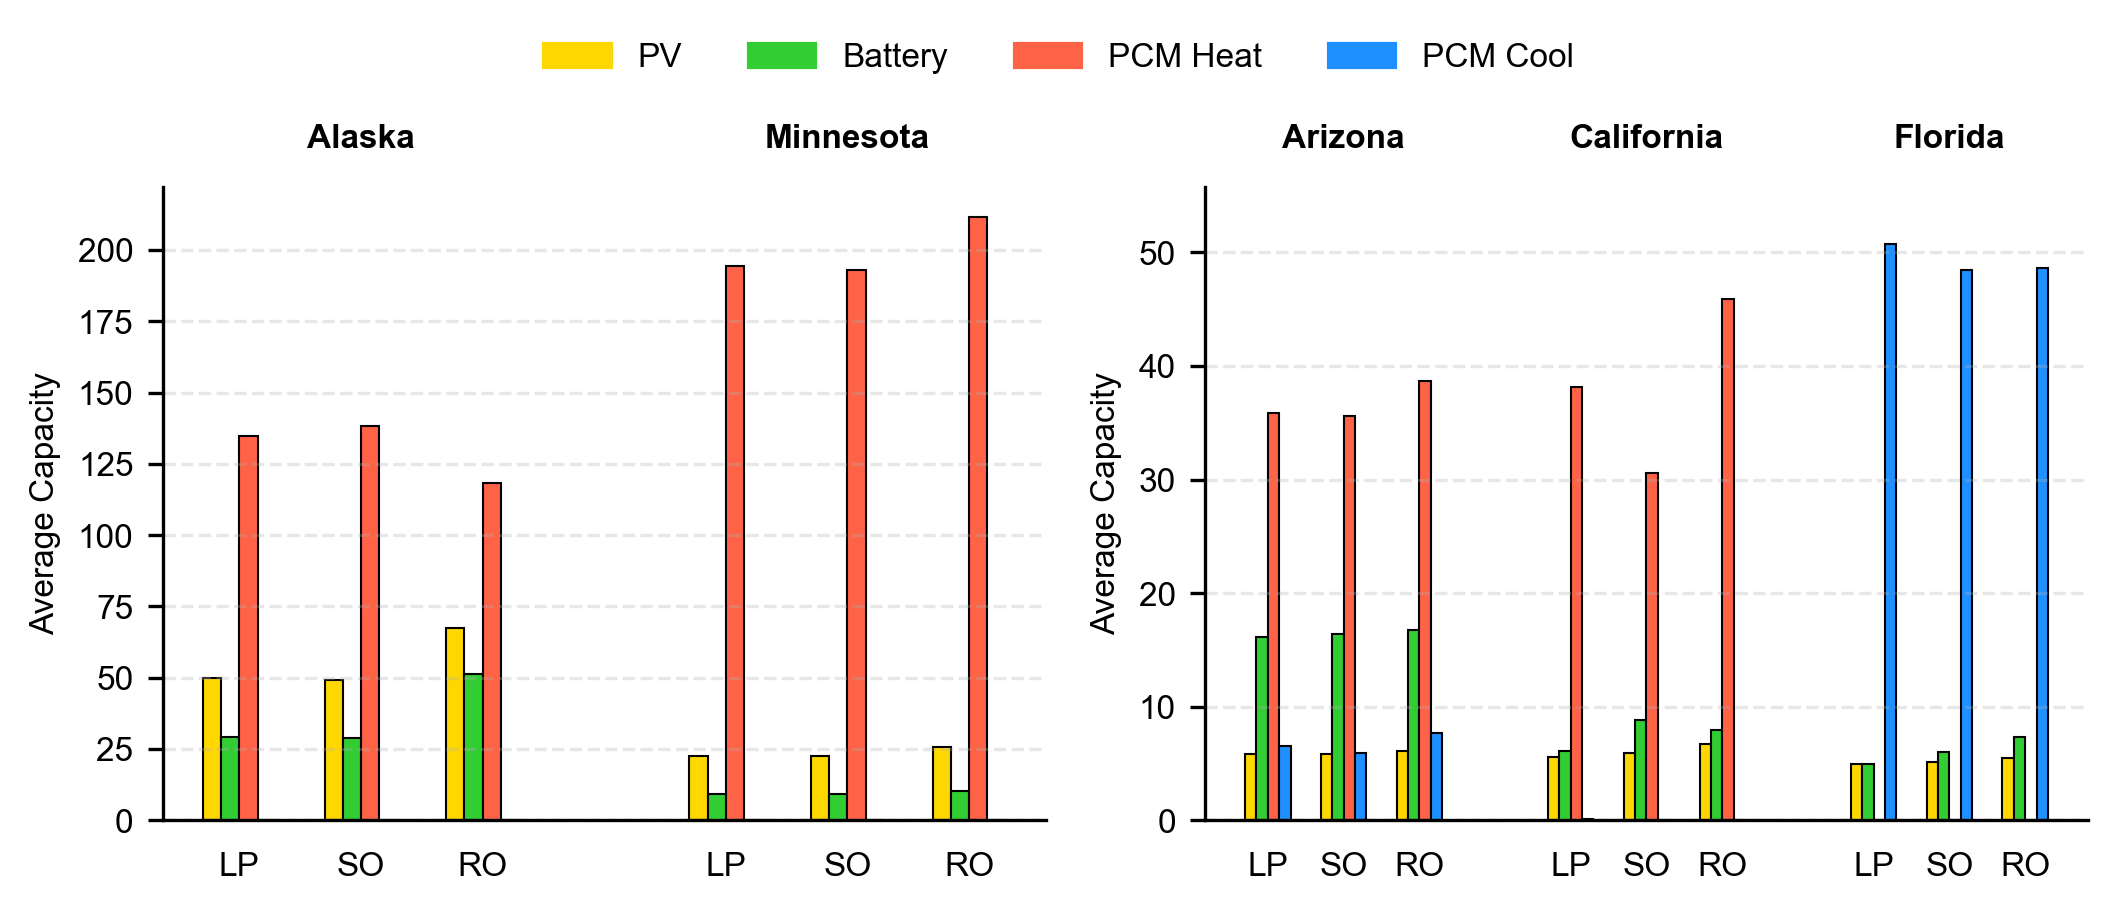

In [30]:
# capacity bar plot
special_scenarios = ['Alaska', 'Minnesota']
scenario_capacity_barplot_loc(location_data, SA_name, "Locations_2", special_scenarios)

## Applications

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

def plot_grouped_stacked_bars_ieee_applications(data, SA_name, plot_name):
    # IEEE-compliant font and style
    mpl.rcParams['figure.dpi'] = 300
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 8

    stacked_df = prepare_stacked_data(data, SA_name)
    print("Available applications:", stacked_df[SA_name].unique())

    desired_order = ['DC', 'RC', 'FOB']
    applications = [app for app in desired_order if app in stacked_df[SA_name].unique()]
    algorithms = ['LP', 'SO', 'RO']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # CaPEX, OPEX HVAC, OPEX C

    fig_width = 7.16  # IEEE 2-column width
    fig_height = 3.0
    fig, axes = plt.subplots(1, len(applications), figsize=(fig_width, fig_height), dpi=300)

    if len(applications) == 1:
        axes = [axes]  # Ensure iterable

    width = 0.6
    legend_handles = []

    for idx, (ax, app) in enumerate(zip(axes, applications)):
        app_df = stacked_df[stacked_df[SA_name] == app]
        x_pos = np.arange(len(algorithms))
        bottom = np.zeros(len(algorithms))
        for j, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [app_df[app_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            bar = ax.bar(x_pos, values, width, bottom=bottom, color=colors[j], edgecolor='black', linewidth=0.8, label=category)
            if idx == 0:
                legend_handles.append(bar)
            bottom += np.array(values)

        ax.set_xticks(x_pos)
        ax.set_xticklabels(algorithms)
        ax.text(np.mean(x_pos), -0.18, app, ha='center', va='top',
                fontsize=8, fontweight='bold',
                transform=ax.get_xaxis_transform(), clip_on=False)
        ax.set_ylabel('Cost ($)')
        ax.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.legend(['CaPEX', 'OPEX HVAC', 'OPEX C'],
               loc='upper center',
               bbox_to_anchor=(0.5, 0.98),
               ncol=3,
               fontsize=8,
               frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"{plot_name}.png", dpi=300, bbox_inches='tight')
    plt.show()


Available applications: ['RC' 'FOB' 'DC']


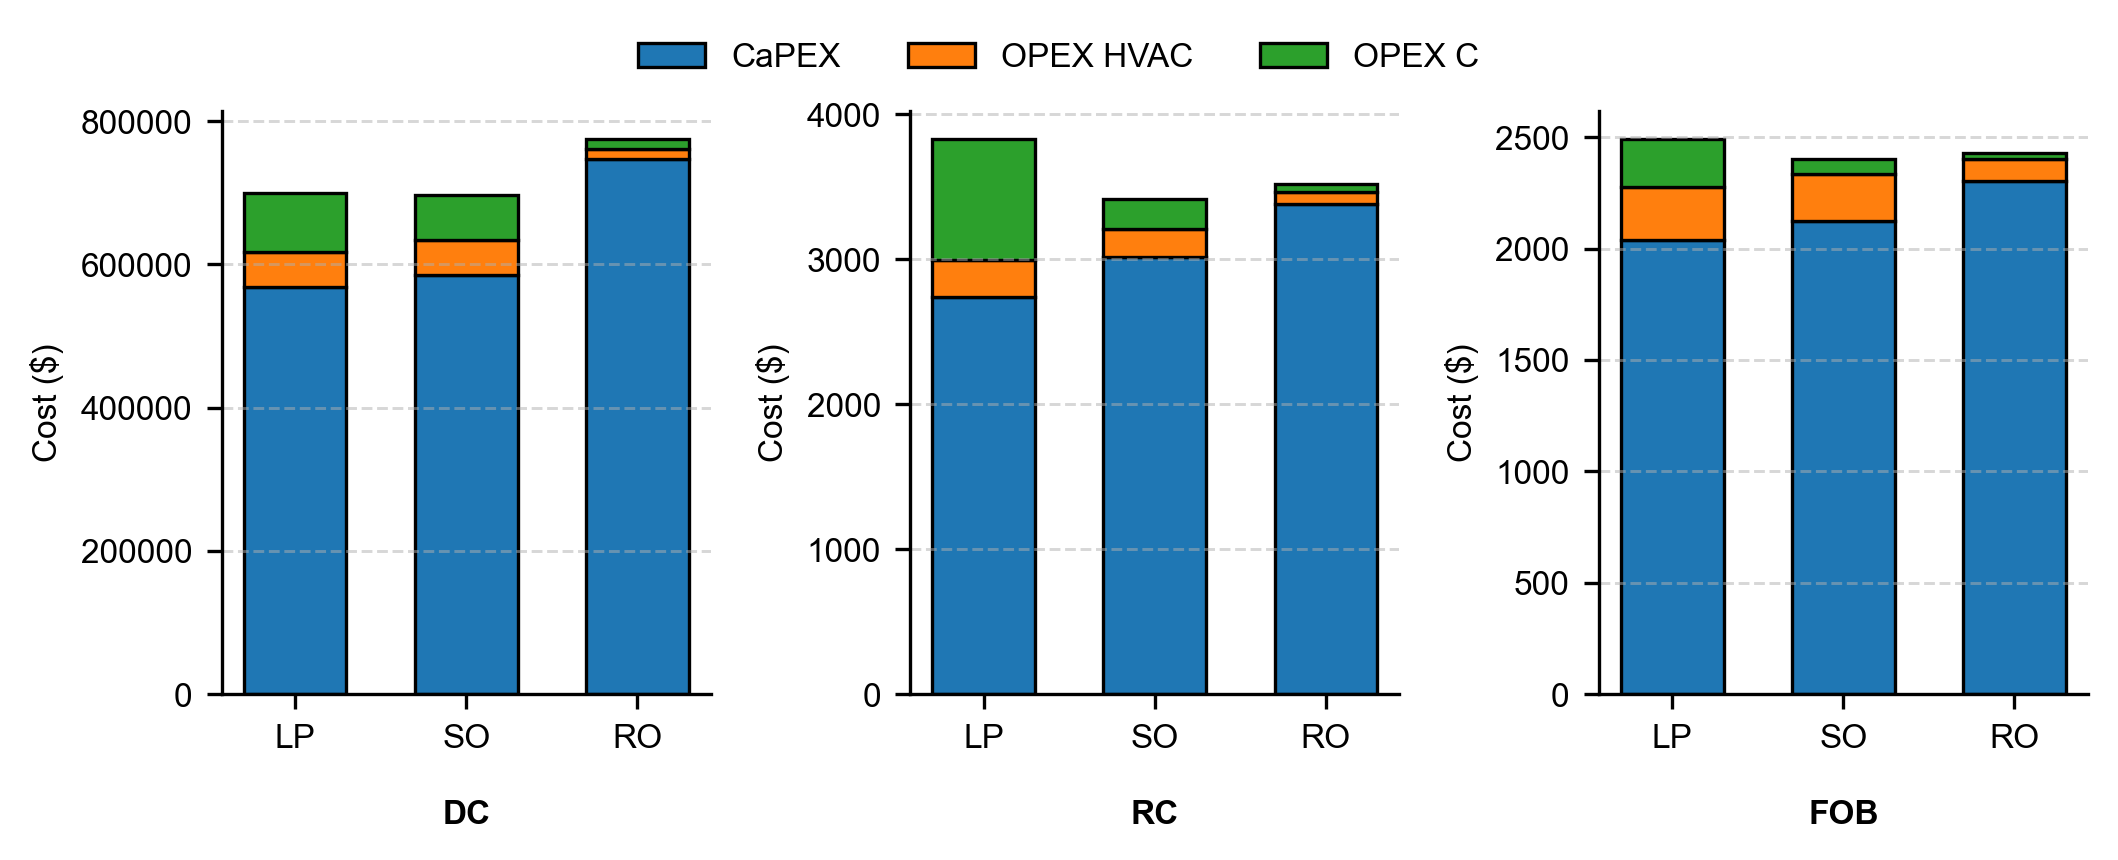

In [33]:
SA_name = 'Scenarios'


scenario_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# Run the plotting function
plot_grouped_stacked_bars_ieee_applications(scenario_data, SA_name, "Applications_1")

/var/folders/ll/cq_mlqg56938kmwh8dys19n80000gn/T/ipykernel_54206/1958248704.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


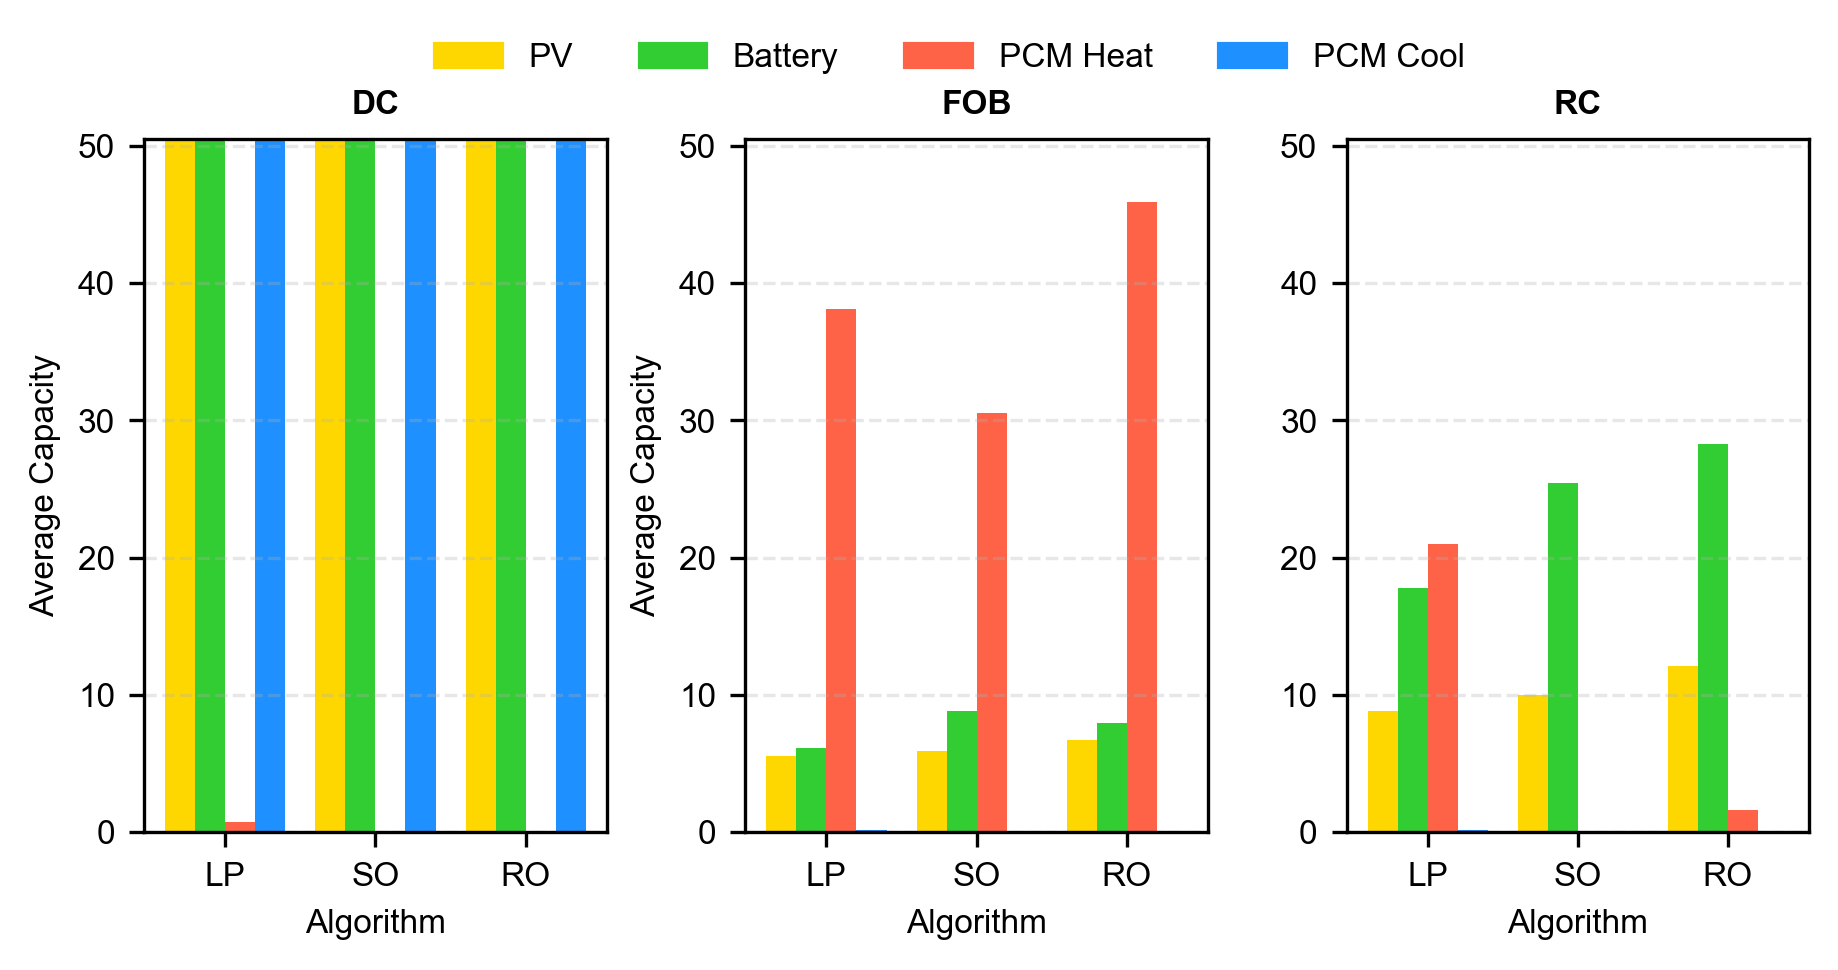

In [36]:
# capacity bar plot
special_scenarios = ['DC']
scenario_capacity_barplot(scenario_data, SA_name, "Applications_2", special_scenarios)

## Capacity Cost Assumptions

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

def plot_grouped_stacked_bars_ieee_cap_cost(data, SA_name, plot_name):
    # Set IEEE-compliant font and style globally
    mpl.rcParams['figure.dpi'] = 300
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 8

    # Prepare data
    stacked_df = prepare_stacked_data(data, SA_name)
    print("Available applications:", stacked_df[SA_name].unique())

    # Desired order
    desired_order = ['HPHB', 'HPLB', 'LPHB', 'LPLB']
    applications = [app for app in desired_order if app in stacked_df[SA_name].unique()]
    algorithms = ['LP', 'SO', 'RO']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # CaPEX, OPEX HVAC, OPEX C

    # Calculate global y-axis limit
    y_max = stacked_df[['CaPEX', 'OPEX HVAC', 'OPEX C']].sum(axis=1).max() * 1.1

    fig_width = 7.16  # IEEE 2-column width
    fig_height = 3.0
    fig, axes = plt.subplots(1, len(applications), figsize=(fig_width, fig_height), dpi=300, sharey=True)

    if len(applications) == 1:
        axes = [axes]  # Ensure axes is iterable

    width = 0.6

    for idx, (ax, app) in enumerate(zip(axes, applications)):
        app_df = stacked_df[stacked_df[SA_name] == app]
        x_pos = np.arange(len(algorithms))
        bottom = np.zeros(len(algorithms))

        for j, category in enumerate(['CaPEX', 'OPEX HVAC', 'OPEX C']):
            values = [app_df[app_df['Algorithm'] == alg][category].values[0] for alg in algorithms]
            ax.bar(x_pos, values, width, bottom=bottom,
                   color=colors[j], edgecolor='black', linewidth=0.8, label=category if idx == 0 else "")
            bottom += np.array(values)

        ax.set_ylim(0, y_max)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(algorithms)

        # Label application under bars
        ax.text(np.mean(x_pos), -0.18, app, ha='center', va='top',
                fontsize=8, fontweight='bold',
                transform=ax.get_xaxis_transform(), clip_on=False)

        if idx == 0:
            ax.set_ylabel('Cost ($)')

        ax.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Legend at top center
    fig.legend(['CaPEX', 'OPEX HVAC', 'OPEX C'],
               loc='upper center',
               bbox_to_anchor=(0.5, 0.98),
               ncol=3,
               fontsize=8,
               frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"{plot_name}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


Available applications: ['HPHB' 'HPLB' 'LPHB' 'LPLB']


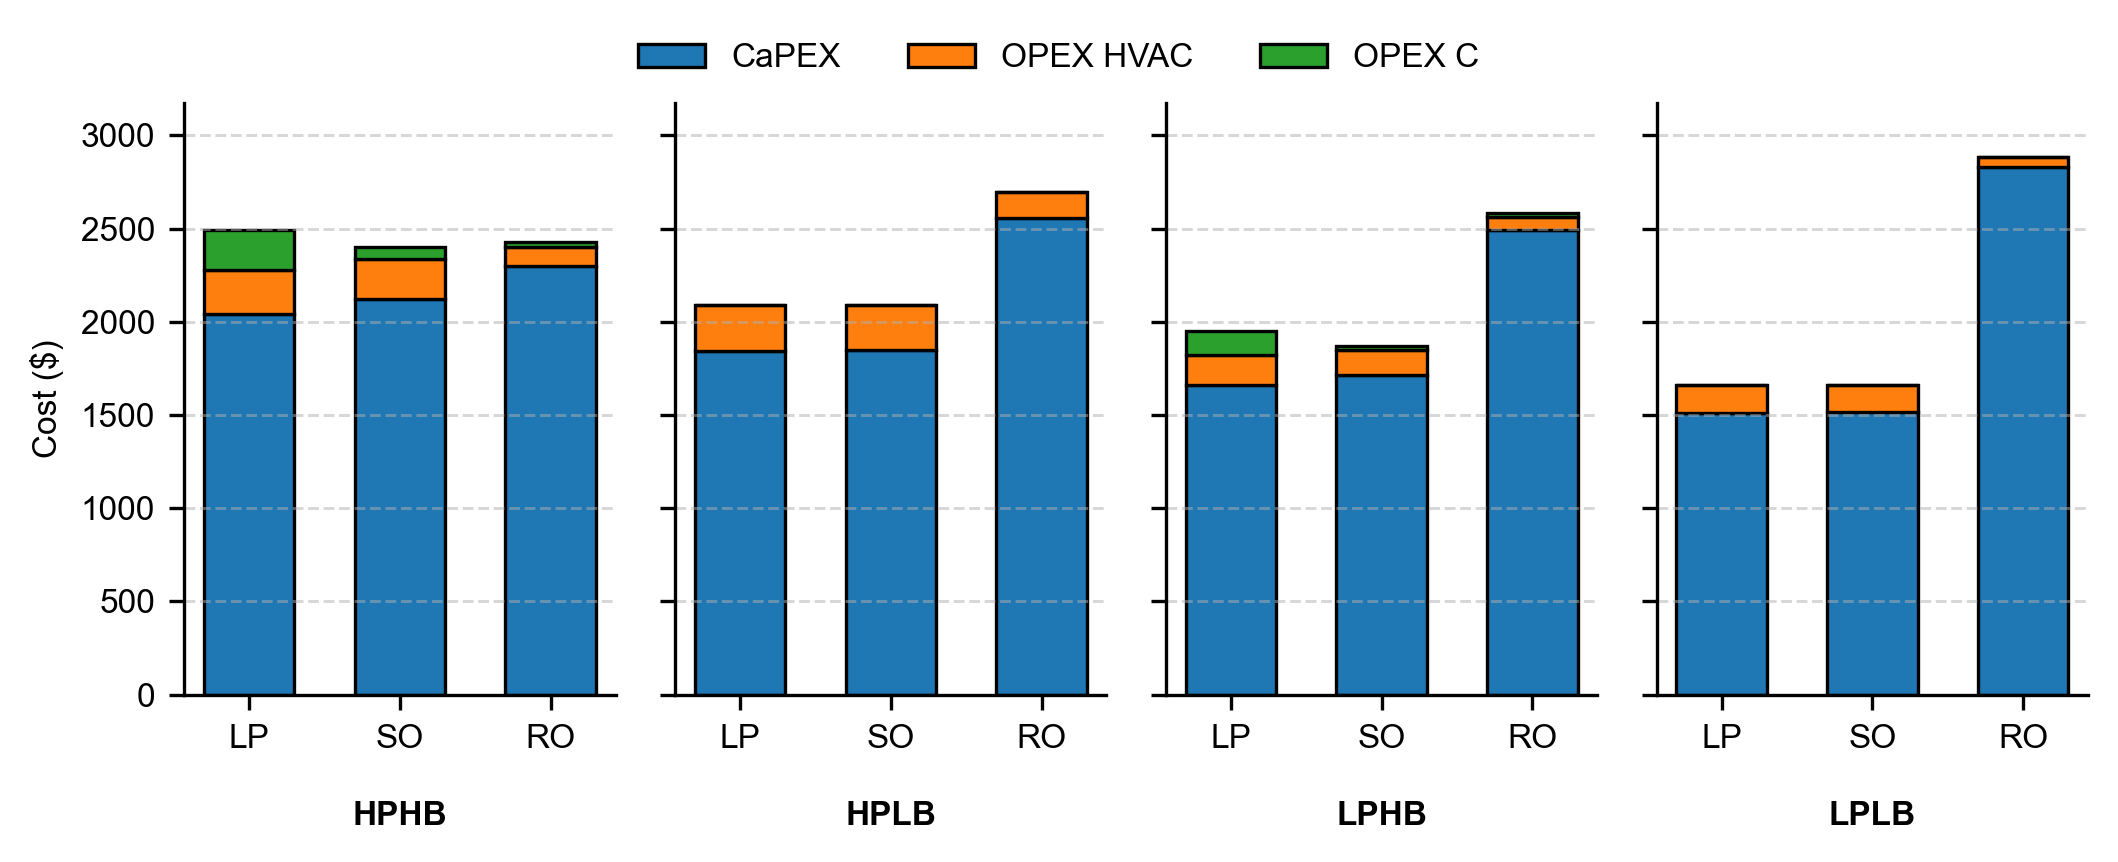

/var/folders/ll/cq_mlqg56938kmwh8dys19n80000gn/T/ipykernel_54206/1958248704.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


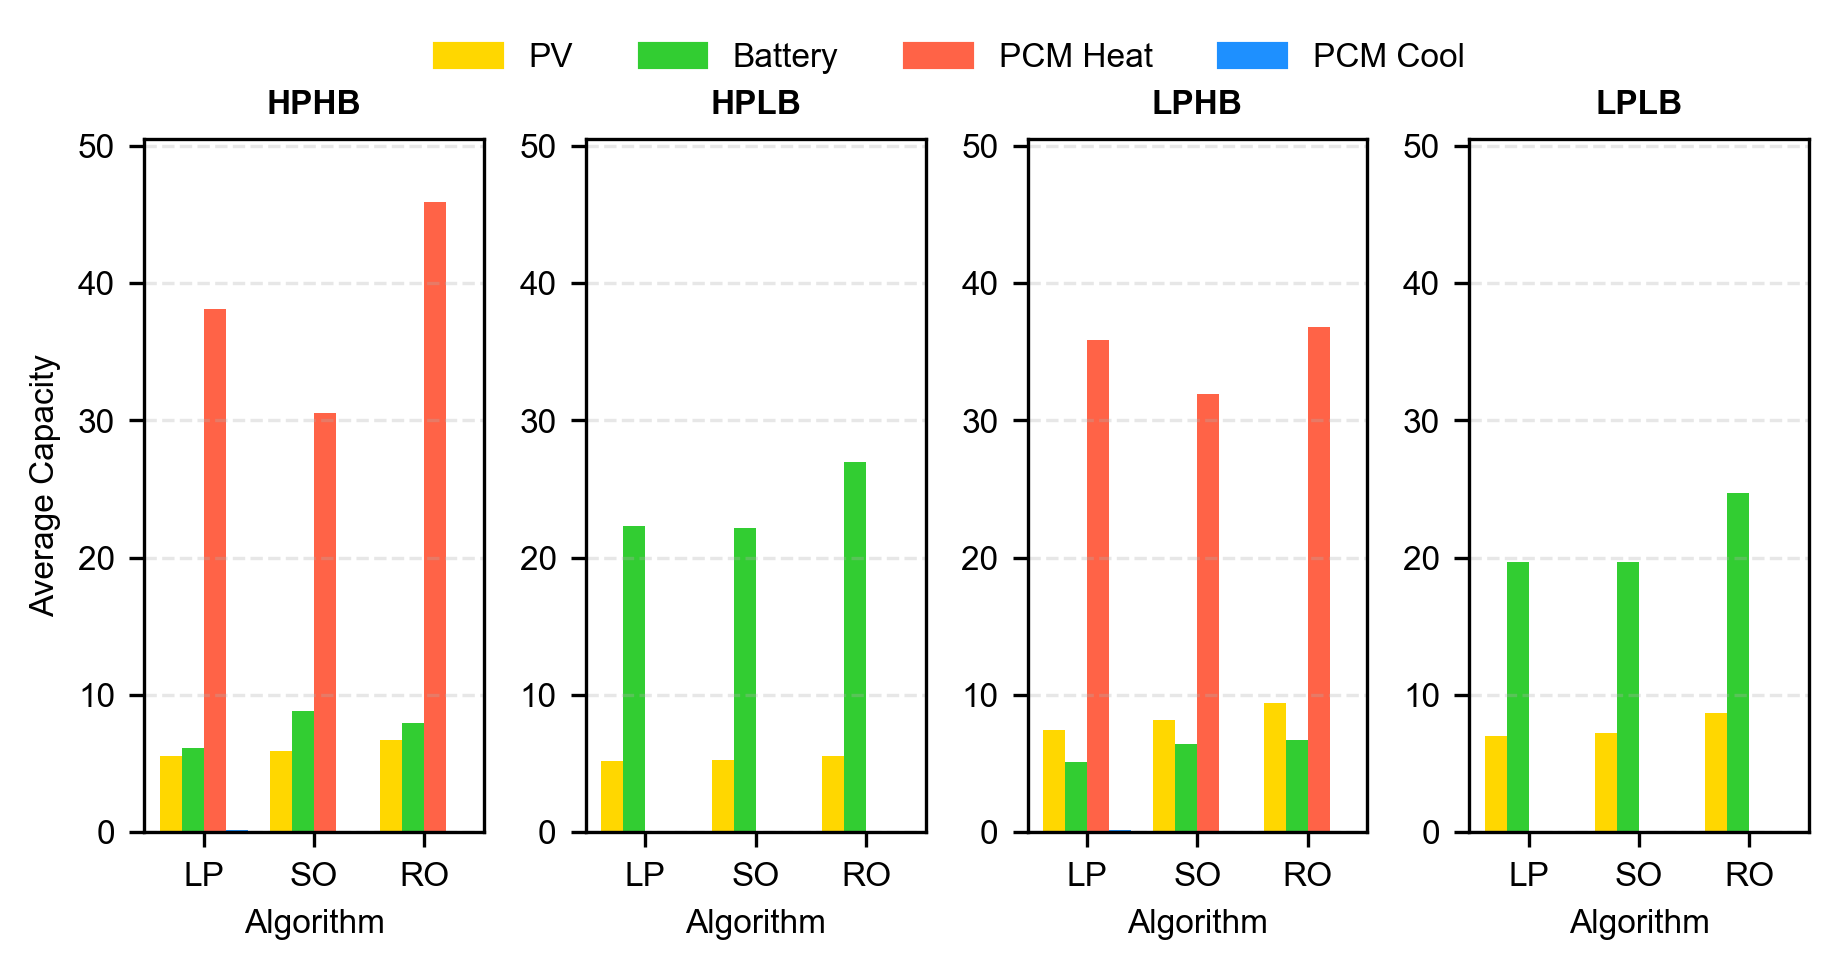

In [39]:
SA_name = 'Capacity_Costs'

# Example usage for Locations:
cap_cost_data = load_data(
    folder_path=os.path.join('Safe_Results', f'SA_{SA_name}'),
    pattern_prefix=SA_name
)

# capacity bar plot
# Run the plotting function
plot_grouped_stacked_bars_ieee_cap_cost(cap_cost_data, SA_name, "Capacity Cost Assumptions_1")

special_scenarios = []
scenario_capacity_barplot(cap_cost_data, SA_name, "Capacity Cost Assumptions_2", special_scenarios)

## Load Yearly Data

In [14]:
def load_yearly_data_nested(folder_name, file_name):
    """
    Load location data into nested dictionary structure:
    location_data_yr[location][year][variable] = value
    
    Args:
        folder_name: Name of the folder containing the file
        file_name: Name of the Excel file
        
    Returns:
        Nested dictionary {location: {year: {variable: value}}}
    """
    file_path = os.path.join(folder_name, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    try:
        all_sheets = pd.read_excel(file_path, sheet_name=None)
    except Exception as e:
        raise ValueError(f"Error reading Excel file: {str(e)}")
    
    location_data_yr = {}
    
    for sheet_name, df in all_sheets.items():
        # Initialize location dictionary
        location_data_yr[sheet_name] = {}
        
        # Convert Year column to integer
        df['Year'] = df['Year'].astype(int)
        
        # Iterate through each row (year) in the sheet
        for _, row in df.iterrows():
            year = row['Year']
            location_data_yr[sheet_name][year] = {
                'var PV': row['var PV'],
                'var E_Load': row['var E_Load'],
                'var Cooling_Load': row['var Cooling_Load'],
                'var Heating_Load': row['var Heating_Load'],
                'CV PV': row['CV PV'],
                'CV E_Load': row['CV E_Load'],
                'CV Cooling_Load': row['CV Cooling_Load'],
                'CV Heating_Load': row['CV Heating_Load'],
                'Total pv (kWh/kW Capacity)': row['Total pv (kWh/kW Capacity)'],
                'Total E_Load (kWh)': row['Total E_Load (kWh)'],
                'Total Cooling_Load (kWh T)': row['Total Cooling_Load (kWh T)'],
                'Total Heating_Load (kWh T)': row['Total Heating_Load (kWh T)']
            }
    
    return location_data_yr

In [15]:
location_data_yr = load_yearly_data_nested("Yearly_Results", "locations_result.xlsx")
scenario_data_yr = load_yearly_data_nested("Yearly_Results", "scenarios_result.xlsx")

fold = 5
weather_year_list = list(range(1998, 2023))  # 1998-2022 (25 years total)
algorithms = ["LP", "SO", "RO"]

## Calculate cost per energy served for Locations Sensivity Run

In [16]:
# Initialize the dictionary properly
cost_per_energy_served_loc = {}

for loc in location_data_yr.keys():  # Added parentheses for .keys() method
    # Initialize location in dictionary
    cost_per_energy_served_loc[loc] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_loc[loc][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = location_data[loc][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([location_data_yr[loc][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                location_data_yr[loc][yr]["Total Cooling_Load (kWh T)"] + 
                location_data_yr[loc][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            denominator = (
                (total_e_load/5 - critical_load_cost/300) + 
                (total_thermal_load/5 - hvac_cost/3)
            )
            
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_loc[loc][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_loc[loc][k][algo] = numerator / denominator

## Calculate cost per energy served for Capacity Cost Assumption Sensivity Run

In [17]:
# Initialize the dictionary properly
cost_per_energy_served_cap = {}

caps = ["HPHB", "HPLB", "LPHB", "LPLB"]

for cap in caps: 
    # Initialize location in dictionary
    cost_per_energy_served_cap[cap] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_cap[cap][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = cap_cost_data[cap][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([location_data_yr["California"][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                location_data_yr["California"][yr]["Total Cooling_Load (kWh T)"] + 
                location_data_yr["California"][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            denominator = (
                (total_e_load/5 - critical_load_cost/300) + 
                (total_thermal_load/5 - hvac_cost/3)
            )
            
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_cap[cap][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_cap[cap][k][algo] = numerator / denominator


## Calculate cost per energy served for Scenario Sensivity Run

In [18]:
# Initialize the dictionary properly
cost_per_energy_served_sce = {}

sces = ["FOB", "DC", "RC"]

for sce in sces: 
    # Initialize location in dictionary
    cost_per_energy_served_sce[sce] = {}
    
    for k in range(fold):
        # Initialize fold in dictionary
        cost_per_energy_served_sce[sce][k] = {}
        
        # Get testing years (5-year chunks)
        start_idx = k * 5
        testing_year_list = weather_year_list[start_idx : start_idx + 5]
        training_year_list = [y for y in weather_year_list if y not in testing_year_list]
        
        # Get the fold data
        df = scenario_data[sce][f'Fold_{k+1}']  # Assuming folds are numbered 1-5
        
        for algo in algorithms:
            # Extract algorithm-specific costs
            algo_df = df[df['Algorithm'] == algo]
            if len(algo_df) == 0:
                continue  # Skip if no data for this algorithm
                
            capital_cost = algo_df['Testing Capital Cost'].values[0]
            critical_load_cost = algo_df['Testing Critical Load Cost'].values[0]
            hvac_cost = algo_df['Testing HVAC Cost'].values[0]
            
            # Calculate energy sums
            total_e_load = np.sum([scenario_data_yr[sce][yr]["Total E_Load (kWh)"] for yr in testing_year_list])
            total_thermal_load = np.sum([
                scenario_data_yr[sce][yr]["Total Cooling_Load (kWh T)"] + 
                scenario_data_yr[sce][yr]["Total Heating_Load (kWh T)"]
                for yr in testing_year_list
            ])
            
            # Calculate cost per energy served
            numerator = capital_cost
            if sce == 'DC':            
                denominator = (
                    (total_e_load/5 - critical_load_cost/30) + 
                    (total_thermal_load/5 - hvac_cost/10)
                )
            else:
                denominator = (
                    (total_e_load/5 - critical_load_cost/300) + 
                    (total_thermal_load/5 - hvac_cost/3)
                )
                
            # Avoid division by zero
            if denominator <= 0:
                cost_per_energy_served_sce[sce][k][algo] = None  # or np.nan
            else:
                cost_per_energy_served_sce[sce][k][algo] = numerator / denominator

## Cost per energy served box plot

In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

def plot_cost_per_energy_boxplots(cost_per_energy_served_loc, SA_name, plot_name='cost_per_energy_boxplot'):
    """
    Create IEEE-style box plots of cost per energy served for each location, with algorithms compared.
    Args:
        cost_per_energy_served_loc: Dict of structure {loc: {fold: {algo: value}}}
        SA_name: Name of the scenario axis (e.g. "Location")
        plot_name: Filename to export figure
    """
    # Set IEEE-compliant font and style
    mpl.rcParams['figure.dpi'] = 300
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 8

    # Convert dictionary to DataFrame
    plot_data = []
    for loc in cost_per_energy_served_loc:
        for fold in cost_per_energy_served_loc[loc]:
            for algo in cost_per_energy_served_loc[loc][fold]:
                value = cost_per_energy_served_loc[loc][fold][algo]
                if value is not None:
                    plot_data.append({
                        SA_name: loc,
                        'Fold': fold,
                        'Algorithm': algo,
                        'Cost per Energy Served': value
                    })
    df = pd.DataFrame(plot_data)

    # Sort locations and set up subplots
    locations = sorted(df[SA_name].unique())
    n_locations = len(locations)
    fig_width = 7.16  # IEEE 2-column width
    fig_height = 3    # Reasonable height
    fig, axes = plt.subplots(1, n_locations, figsize=(fig_width, fig_height), sharey=True)

    if n_locations == 1:
        axes = [axes]

    algo_colors = {
        'LP': '#1f77b4',
        'SO': '#ff7f0e',
        'RO': '#2ca02c'
    }

    # Determine y-axis limits
    y_min, y_max = np.inf, -np.inf
    for loc in locations:
        loc_data = df[df[SA_name] == loc]
        for algo in ['LP', 'SO', 'RO']:
            vals = loc_data[loc_data['Algorithm'] == algo]['Cost per Energy Served']
            if not vals.empty:
                y_min = min(y_min, vals.min())
                y_max = max(y_max, vals.max())
    y_margin = 0.05 * (y_max - y_min)
    y_limits = (y_min - y_margin, y_max + y_margin)

    # Plot each location
    for ax, loc in zip(axes, locations):
        loc_data = df[df[SA_name] == loc]
        box_data = [
            loc_data[loc_data['Algorithm'] == algo]['Cost per Energy Served'].dropna().values
            for algo in ['LP', 'SO', 'RO']
        ]
        box = ax.boxplot(
            box_data,
            patch_artist=True,
            widths=0.6,
            flierprops=dict(marker='o', markersize=2, markerfacecolor='white', markeredgecolor='gray')
        )


        for median in box['medians']:
            median.set(color='black', linewidth=1.2)
        for patch, algo in zip(box['boxes'], ['LP', 'SO', 'RO']):
            patch.set_facecolor(algo_colors[algo])

        ax.set_title(loc, fontsize=8, fontweight='bold')
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels(['LP', 'SO', 'RO'])
        ax.set_ylabel('Cost per Energy Served [$/kWh]' if ax == axes[0] else '')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_ylim(y_limits)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Create legend
    handles = [mpl.patches.Patch(color=algo_colors[algo], label=algo) for algo in ['LP', 'SO', 'RO']]
    fig.legend(handles=handles,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.02),
               ncol=3,
               fontsize=8,
               frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{plot_name}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


## Plot Cost per Energy Served Plots

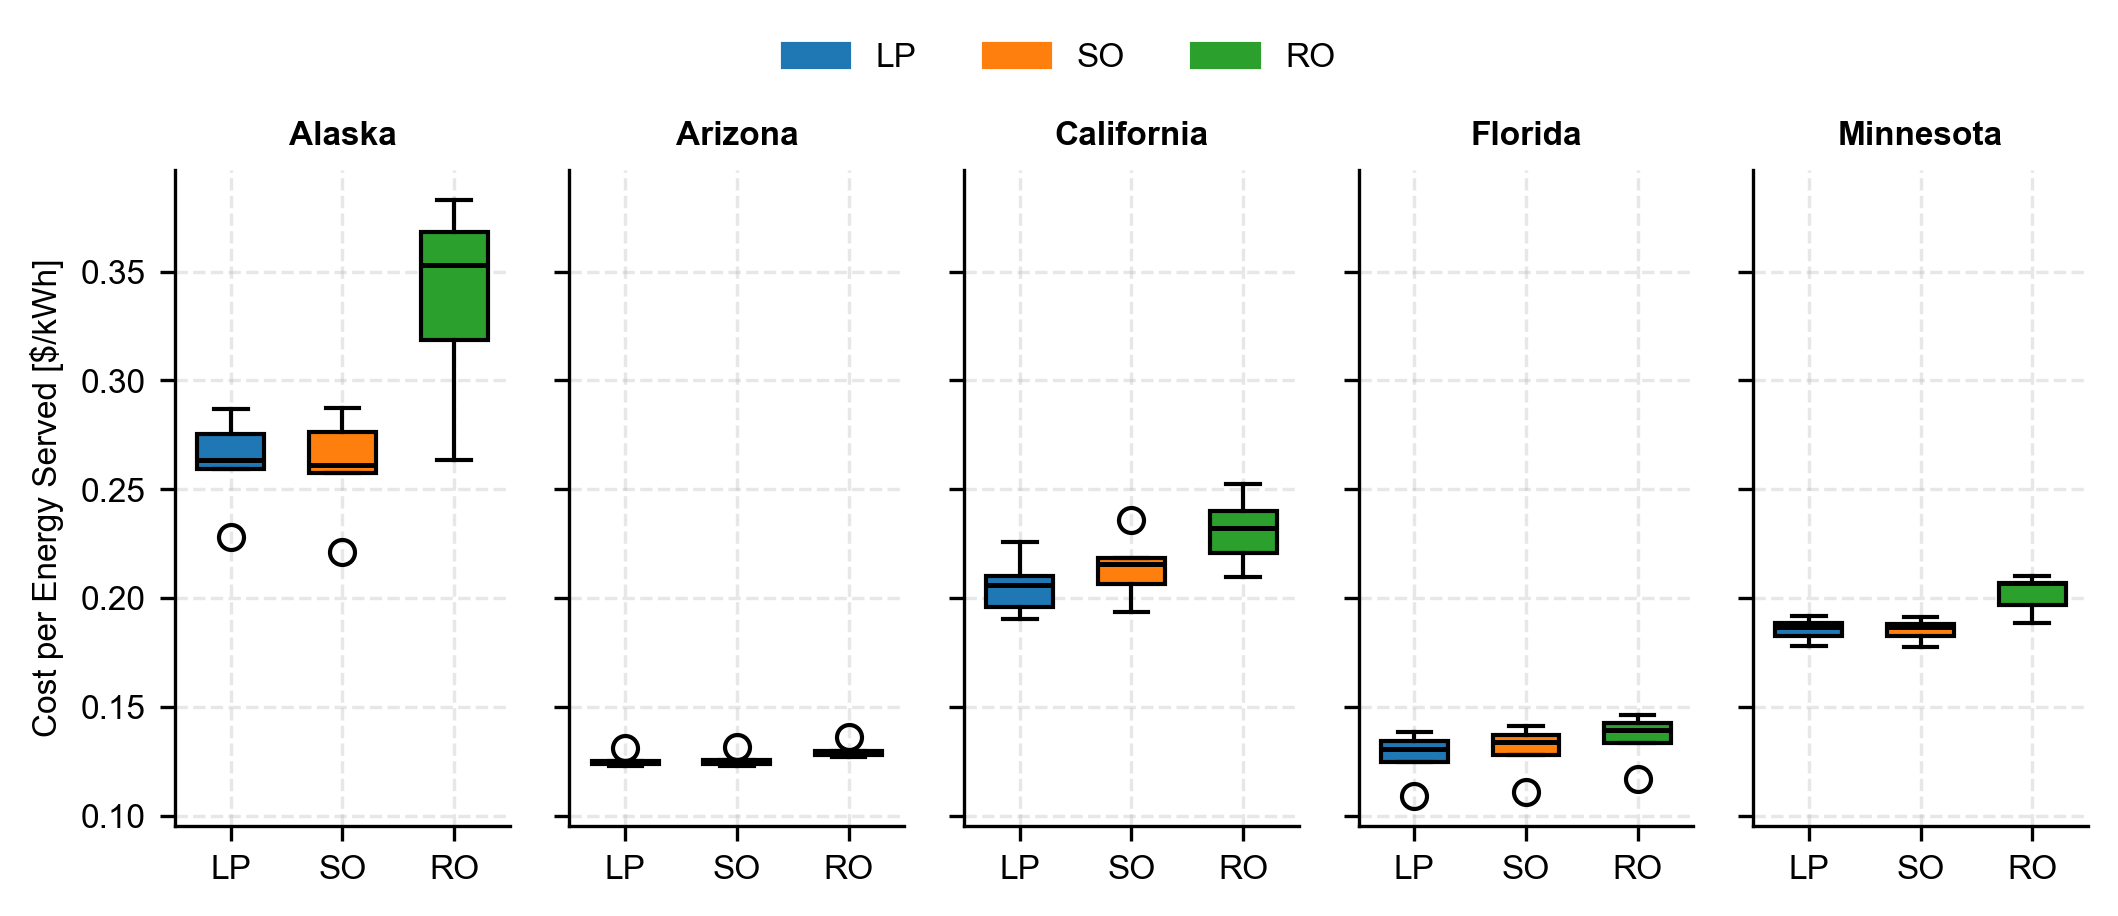

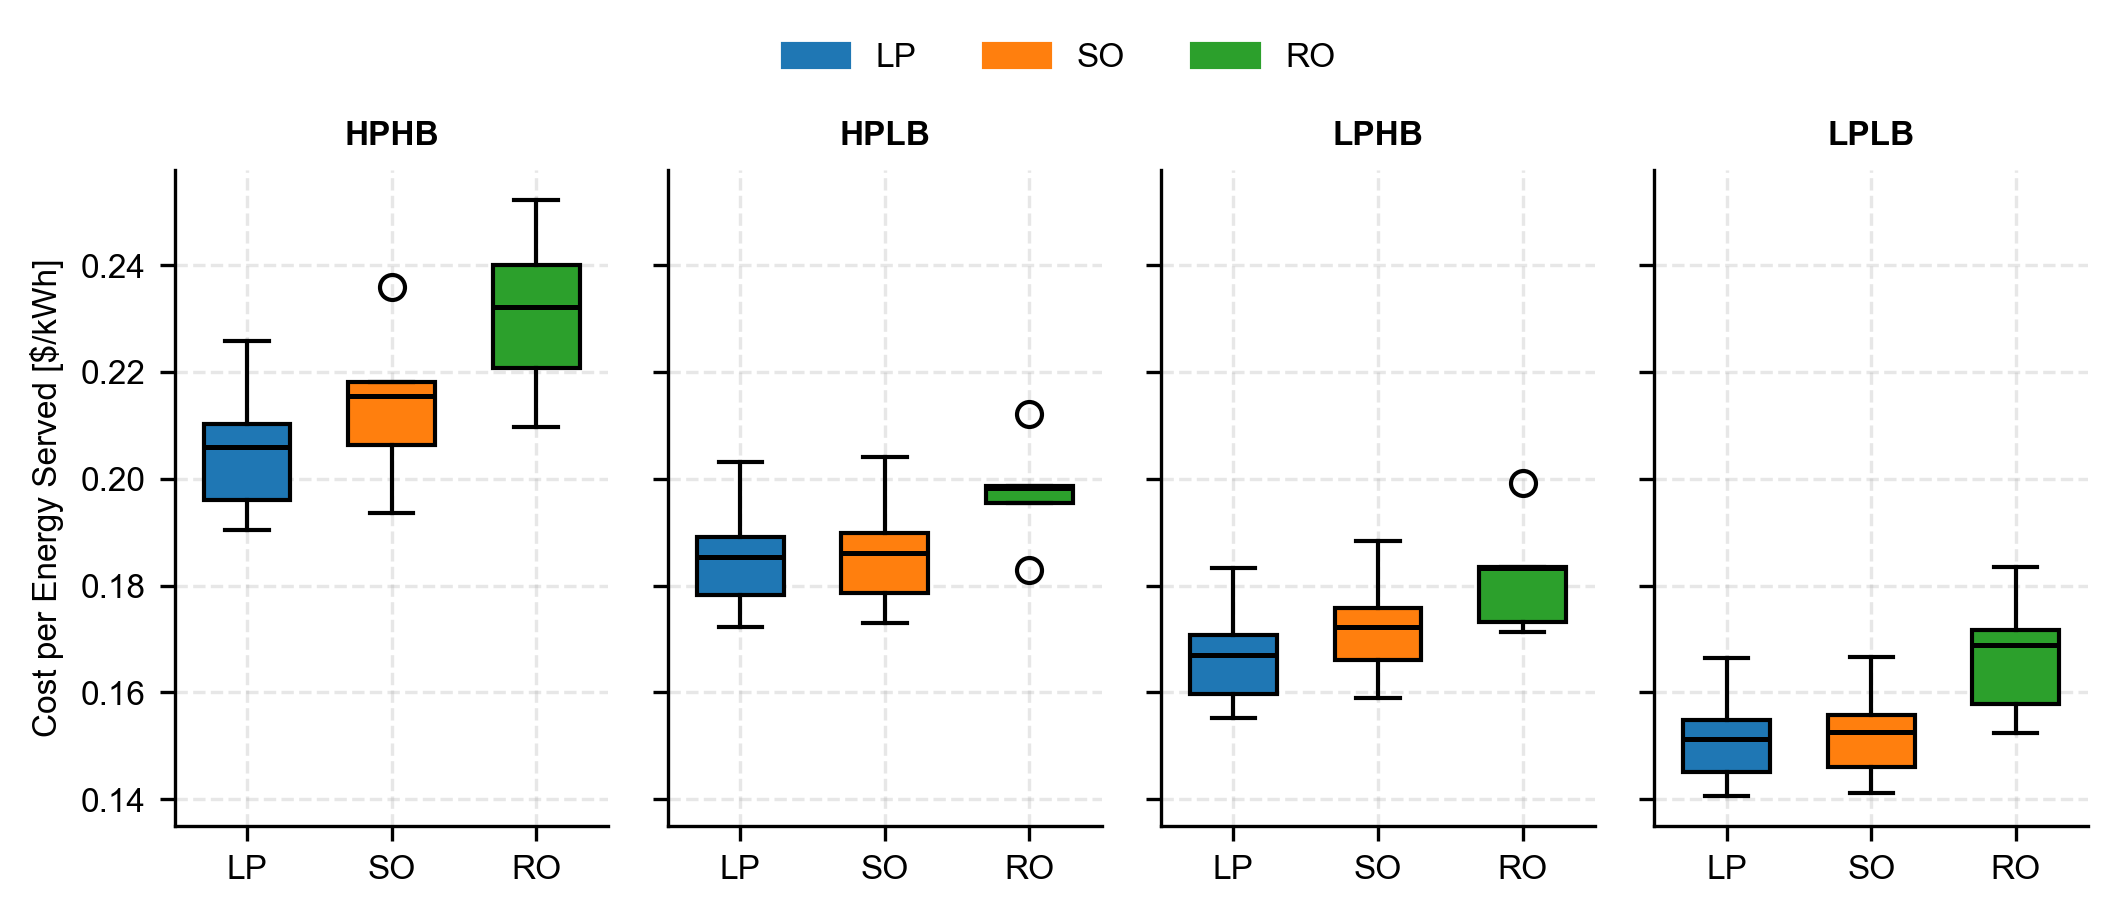

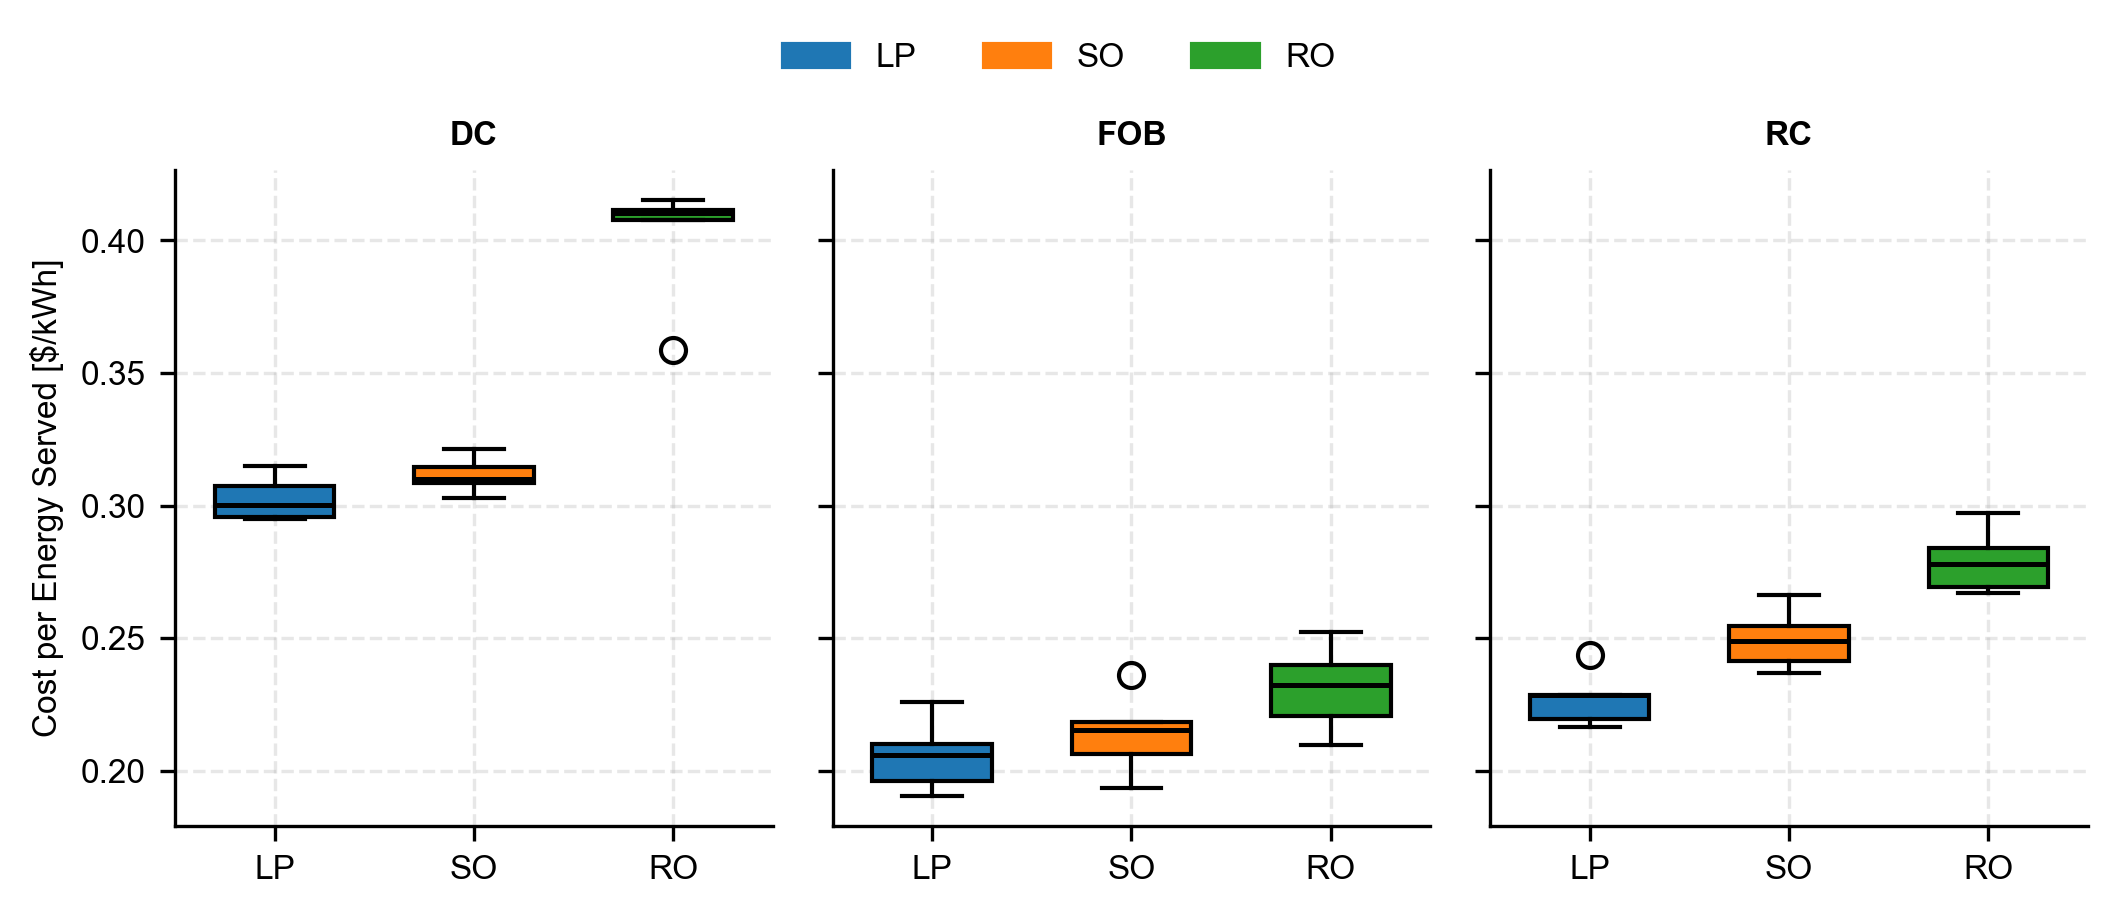

In [41]:

plot_cost_per_energy_boxplots(cost_per_energy_served_loc, 'Location_3')
plot_cost_per_energy_boxplots(cost_per_energy_served_cap, 'Capacity Cost Assumption_3')
plot_cost_per_energy_boxplots(cost_per_energy_served_sce, 'Scenarios_3')

## Scatter Plot (Unused)

In [21]:
from matplotlib.patches import Rectangle

def prepare_scatter_data(data_dict, category_name):
    """Convert nested dictionary to DataFrame with category label"""
    scatter_data = []
    
    for sub_category, folds in data_dict.items():
        for fold_num, df in folds.items():
            for _, row in df.iterrows():
                scatter_data.append({
                    'Category': category_name,
                    'SubCategory': sub_category,
                    'Fold': fold_num,
                    'Algorithm': row['Algorithm'],
                    'CaPEX': row['Training Capital Cost'],
                    'OPEX': row['Testing HVAC Cost'] + row['Testing Critical Load Cost']
                })
    return pd.DataFrame(scatter_data)

all_data = pd.concat([
    prepare_scatter_data(location_data, 'Locations'),
    prepare_scatter_data(cap_cost_data, 'Capacity Costs'),
    prepare_scatter_data(scenario_data, 'Scenarios')
])

def scatter_faceted_by_category_with_ols(
    all_data,
    category_order=['Locations', 'Scenarios', 'Capacity Costs'],
    algorithm_colors={'LP': '#1f77b4', 'SO': '#ff7f0e', 'RO': '#2ca02c'},
    marker_styles=None
):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib as mpl
    import statsmodels.api as sm

    # Set IEEE style
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['axes.titlesize'] = 8
    mpl.rcParams['axes.labelsize'] = 8
    mpl.rcParams['xtick.labelsize'] = 8
    mpl.rcParams['ytick.labelsize'] = 8
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['figure.titlesize'] = 14

    # Most distinctive matplotlib markers
    base_markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '>', '<']

    n_cats = len(category_order)
    fig, axes = plt.subplots(1, n_cats, figsize=(5*n_cats + 2, 4), dpi=300, sharey=False)
    if n_cats == 1:
        axes = [axes]

    from matplotlib.lines import Line2D

    for idx, category in enumerate(category_order):
        ax = axes[idx]
        cat_data = all_data[all_data['Category'] == category]
        subcats_in_panel = sorted(cat_data['SubCategory'].unique())
        # Assign markers per panel
        panel_marker_styles = {subcat: base_markers[i % len(base_markers)] for i, subcat in enumerate(subcats_in_panel)}
        # Plot each subcategory with its marker
        for subcat in subcats_in_panel:
            subcat_data = cat_data[cat_data['SubCategory'] == subcat]
            for alg, color in algorithm_colors.items():
                alg_data = subcat_data[subcat_data['Algorithm'] == alg]
                if not alg_data.empty:
                    ax.scatter(
                        alg_data['CaPEX'], alg_data['OPEX'],
                        color=color,
                        marker=panel_marker_styles[subcat],
                        label=f"{alg}-{subcat}",
                        edgecolor='w', linewidth=0.7, s=70, alpha=0.9
                    )
        # OLS fit for each algorithm
        for alg, color in algorithm_colors.items():
            alg_data = cat_data[cat_data['Algorithm'] == alg]
            if len(alg_data) > 1:
                X = alg_data['CaPEX']
                Y = alg_data['OPEX']
                X_ = sm.add_constant(X)
                model = sm.OLS(Y, X_).fit()
                x_pred = np.linspace(X.min(), X.max(), 100)
                y_pred = model.predict(sm.add_constant(x_pred))
                ax.plot(x_pred, y_pred, color=color, linewidth=2, alpha=0.8, linestyle='dashdot', label=f"{alg} OLS")
        ax.set_xlabel('CaPEX ($)', fontsize=8)
        if idx == 0:
            ax.set_ylabel('OPEX ($)', fontsize=8)
        ax.set_title(category, fontsize=10, fontweight='bold')
        ax.grid(axis='both', linestyle='--', alpha=0.5, linewidth=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Subcategory legend for this panel, outside the plot
        marker_legend = [Line2D([0], [0], marker=panel_marker_styles[subcat], color='gray', label=subcat,
                                markerfacecolor='gray', markersize=10, linestyle='None')
                         for subcat in subcats_in_panel]
        ax.legend(handles=marker_legend, title='SubCategory', loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8, frameon=False)

    # Global algorithm legend (color)
    color_legend = [Line2D([0], [0], marker='o', color='w', label=alg,
                           markerfacecolor=color, markersize=8)
                    for alg, color in algorithm_colors.items()]
    fig.legend(handles=color_legend, title='Algorithm', loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=len(algorithm_colors), fontsize=8, frameon=False)

    # plt.suptitle('CaPEX vs OPEX by Category, Algorithm, and SubCategory', y=1.08, fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()